In [1]:
import jax
import jax.numpy as jnp
from dataclasses import dataclass, field
import rich
import pprint as pp

### The Bayes Theorem

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

Where:
- $P(A|B)$ is the probability of event A occurring given that B is true.
- $P(B|A)$ is the probability of event B occurring given that A is true.



In [2]:
@dataclass
class Coin(dict):
    """A dataclass to represent a coin with a head and tail probability.
     ```python
    coin = Coin(0.5)
    coin[True]
    # 0.5
    ```
    """

    p_head: float
    p_tail: float = field(init=False)

    def __post_init__(self):
        self.p_tail = 1.0 - self.p_head

    def __getitem__(self, key: bool) -> float:
        """Overload the __getitem__ method to return the probability of the coin.
        ```python
        coin = Coin(0.5)
        coin[True]
        # 0.5
        ```

        Args:
            key (bool): The key to get the probability of the coin.

        Returns:
            float: The probability of the coin.
        """
        return self.p_head if key else self.p_tail


def flip_coin(key: jnp.ndarray, coin: Coin) -> bool:
    """Flip a coin and return the result.

    Args:
        key (jnp.ndarray): random key
        coin (Coin): The `Coin` object to flip.

    Returns:
        bool: The result of the coin flip. True for heads, False for tails.
    """
    res = jax.random.bernoulli(key, coin[True])
    return True if res else False


def marginal_probability(
    data: bool, coins: dict[int, Coin], box: dict[int, float]
) -> float:
    """Calculate the marginal probability of the data.

    Args:
        data (bool): The data to calculate the marginal probability of.
        coins (dict): All possible coins.
        box (dict): The prior probability of each coin.

    Returns:
        float: The marginal probability of the data.
    """
    return sum(
        # P(Coin) * P(Data|Coin)
        box[coin] * coins[coin][data]
        for coin in coins
    )


def posterior_probability(
    data: bool, coins: dict[int, Coin], prior_box: dict[int, float]
) -> dict[int, float]:
    """Calculate the posterior probability of the data.

    Args:
        data (bool): The data to calculate the posterior probability of.
        coins (dict): All possible coins.
        prior_box (dict): The prior probability of each coin.

    Returns:
        dict: The posterior probability of the data.
    """
    marginal = marginal_probability(data, coins, prior_box)
    return {coin: (prior_box[coin] * coins[coin][data]) / marginal for coin in coins}

def get_most_probable_coin(posterior: dict[int, float]) -> int:
    """Get the most probable coin from the posterior probability.

    Args:
        posterior (dict): The posterior probability.

    Returns:
        int: The most probable coin.
    """
    coin_idx = 0
    for coin, prob in posterior.items():
        if coin_idx is None or prob > posterior[coin_idx]:
            coin_idx = coin

    return coin_idx

In [10]:
key = jax.random.key(0)
key, subkey = jax.random.split(key)
# The coins are biased with the following probabilities
coins = {0: Coin(0.5), 1: Coin(0.8), 2: Coin(0.3)}
# The box contains 3 coins with the following probabilities
box = {
    0: 1 / 5,  # 20%
    1: 2 / 5,  # 40%
    2: 2 / 5,  # 40%
}

# The prior probability of each coin
# The uniform prior box is equivalent to knowing nothing about the coins
prior_box = {
    0: 1/3,  # 33.3%
    1: 1/3,  # 33.3%
    2: 1/3,  # 33.3%
}
# Randomly select a coin from the box
random_coin = int(jax.random.choice(
    subkey, jnp.array(list(coins.keys())), p=jnp.array(list(box.values()))
))

### Upate the Belief
1. We start with some prior belief $P(A)$.
2. We observe some evidence $B$.
3. We update our belief to $P(A|B)$ (Posterior Probability).

In [19]:
# The prior probability is the same as the posterior probability at the beginning
# You could play with the prior probability to see how it affects the posterior probability
posterior = prior_box
# Bayesian updating
n_updates = 10000
report_interval = int(n_updates / 10)
flip_data = []
for idx in range(1, n_updates + 1):
    key, subkey = jax.random.split(key)
    # Flip a coin
    data = flip_coin(subkey, coins[random_coin])
    flip_data.append(int(data))
    # Update the posterior probability
    posterior = posterior_probability(data, coins, posterior)

    if idx % report_interval == 0:
        print(f"At [{idx}]:", jax.tree.map(lambda x: round(x, 3), posterior))

print("The most probable coin is: ", get_most_probable_coin(posterior))
print("The hidden coin is: ", random_coin)

At [1000]: {0: 0.0, 1: 0.0, 2: 1.0}
At [2000]: {0: 0.0, 1: 0.0, 2: 1.0}
At [3000]: {0: 0.0, 1: 0.0, 2: 1.0}
At [4000]: {0: 0.0, 1: 0.0, 2: 1.0}
At [5000]: {0: 0.0, 1: 0.0, 2: 1.0}
At [6000]: {0: 0.0, 1: 0.0, 2: 1.0}
At [7000]: {0: 0.0, 1: 0.0, 2: 1.0}
At [8000]: {0: 0.0, 1: 0.0, 2: 1.0}
At [9000]: {0: 0.0, 1: 0.0, 2: 1.0}
At [10000]: {0: 0.0, 1: 0.0, 2: 1.0}
The most probable coin is:  2
The hidden coin is:  2


In [16]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, init_to_feasible
import numpyro.infer.autoguide as autoguide
import optax
import matplotlib.pyplot as plt

In [ ]:
def model(data: jnp.ndarray | None = None):
    # Flip the coin.
    p = numpyro.sample("p", dist.Beta(2, 2))
    return numpyro.sample("coin", dist.BernoulliProbs(probs=p), obs=data)

data = jnp.array(flip_data)
optimizer = numpyro.optim.optax_to_numpyro(optax.adam(0.01))
guide = autoguide.AutoNormal(model, init_loc_fn=init_to_feasible)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(jax.random.key(0), num_steps=10000, data=data)

100%|██████████| 10000/10000 [00:01<00:00, 9002.34it/s, init loss: 6911.6011, avg. loss [9501-10000]: 6048.1034]


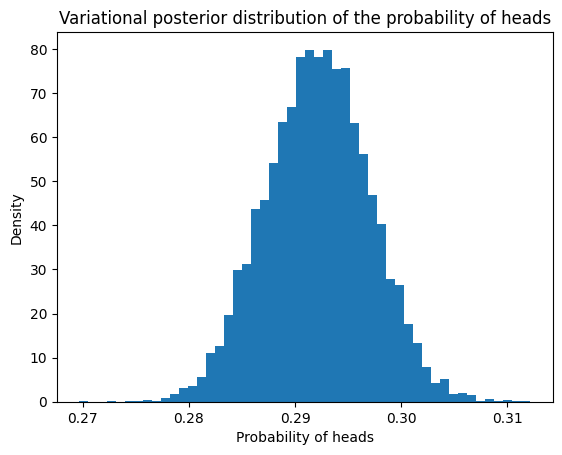

In [23]:
params = svi_result.params

# Sample from the variational distribution
posterior_samples = guide.sample_posterior(jax.random.key(1), params, sample_shape=(10000,))
assert isinstance(posterior_samples, dict)
# Analyze the posterior samples

plt.hist(posterior_samples['p'], bins=50, density=True)
plt.xlabel('Probability of heads')
plt.ylabel('Density')
plt.title('Variational posterior distribution of the probability of heads')
plt.show()